# Kalman Inversion with an Ensemble Transform Filter

We solve a nonlinear, two-parameter inverse problem for a 1-D elliptic equation using mean-field ensemble Kalman inversion based on a square-root filter.

**NOTE**

This version uses the mean-field approach.

## 2-Parameter Elliptic Equation : Probabilistic Approach
Consider the one-dimensional elliptic boundary-value problem

$$
    -\frac{d}{dx}\Big(\exp(\theta_{(1)}) \frac{d}{dx}p(x)\Big) = 1, \qquad x\in[0,1]
$$

with boundary conditions 
$$p(0) = 0, \qquad p(1) = \theta_{(2)}.$$ 

The exact solution for this problem is given by  

$$
    p(x) = \theta_{(2)} x + \exp(-\theta_{(1)})\Big(-\frac{x^2}{2} + \frac{x}{2}\Big).
$$

## Inverse Problem

The inverse problem: given the observations $y = (p(x_1),\,p(x_2))^T$ at $x_1=0.25$ and $x_2=0.75,$ solve for $\theta = (\theta_{(1)},\, \theta_{(2)})^T.$

The Bayesian inverse problem, "given observations $y,$ find the parameter $\theta$",  is formulated as 

$$
    y = \mathcal{G}(\theta) + \eta \qquad \textrm{and} \qquad 
    \mathcal{G}(\theta) = \begin{bmatrix}
    p(x_1, \theta)\\
    p(x_2, \theta)
    \end{bmatrix},
$$
where $\mathcal{G}(\theta)$ is the forward model operator, and the prior is $\mathcal{N}([0, 100]^T,  I)$. We consider two scenarios  

* Well-posed case：the observation is $y=[27.5, 79.7]^T$ with observation error $\eta\sim\mathcal{N}(0, 0.1^2 I)$. 
* Ill-posed case：the observation is $y=[27.5]$ with observation error $\eta\sim\mathcal{N}(0, 0.1^2 I)$. 


## Kalman Inversion by the Mean Field Method

In the code below (see `update_ensemble`), the following mean-field formulation is used.

### Prediction

$$
  \hat{\theta}^j_{n+1} = {m}_{n} + \sqrt{\frac{1}{1-\Delta \tau}} \left(  \theta_n^j - m_n \right),
$$

where $m_n$ is the mean of $\theta_n,$ the analyzed update (or initial condition, if $n=0$), $\Delta \tau = 0.5,$ and $j=1, \ldots, J$ is the ensemble member index.

### Analysis

TBC

In [1]:
import numpy as np
from typing import Callable, Any

# This function can, in princiople, be parallelized... see original "KI.ipynb"
def ensemble(s_param: Any, θ_ens: np.ndarray, forward: Callable) -> np.ndarray:
    N_ens, N_θ = θ_ens.shape
    N_y = s_param.N_y
    g_ens = np.zeros((N_ens, N_y))

    for i in range(N_ens):
        θ = θ_ens[i, :]
        g_ens[i, :] = forward(s_param, θ)   

    return g_ens

## Ensemble Kalman Inversion

Define the `EKI` class. Can be applied to three types of ensemble filters:

- EKI
- EAKI
- ETKI

This one is for an ensemble transform filter, of square-root type, the ETKI. It uses the mean-field approach.

In [2]:
import numpy as np
from scipy import linalg
from scipy.stats import norm

class EKIObj:
    def __init__(self, theta_names, N_ens, theta0_mean, theta_theta0_cov_sqrt,
                 y, Sigma_eta, delta_t):
        self.theta_names = theta_names
        self.theta = [theta0_mean]
        self.y_pred = []
        self.y = y
        self.Sigma_eta = Sigma_eta
        self.N_ens = N_ens
        self.N_theta = len(theta0_mean)
        self.N_y = len(y)
        self.delta_t = delta_t
        self.iter = 0

        print(f"Start ETKI on the mean-field stochastic dynamical system for Bayesian inference")

        # Generate initial ensemble
        self.theta = [self.MvNormal_sqrt(N_ens, theta0_mean, theta_theta0_cov_sqrt)]

    def MvNormal_sqrt(self, N_ens, theta_mean, theta_theta_cov_sqrt):
        N_theta, N_r = theta_theta_cov_sqrt.shape
        theta = np.zeros((N_ens, N_theta))
        for i in range(N_ens):
            theta[i, :] = theta_mean + theta_theta_cov_sqrt @ norm.rvs(size=N_r)
        return theta

    
    def update_ensemble(self, ens_func):
        self.iter += 1
        theta = self.theta[-1]
        Sigma_nu = (1/self.delta_t) * self.Sigma_eta

        # Prediction step
        #################
        theta_p      = np.zeros_like(theta)
        theta_mean   = np.mean(theta, axis=0)
        theta_p_mean = theta_mean
        for j in range(self.N_ens):
            theta_p[j] = theta_p_mean + np.sqrt( 1/(1 - self.delta_t) ) * (theta[j] - theta_mean)

        theta_p_mean = np.mean(theta_p, axis=0)

        # Analysis step
        ###############
        g = ens_func(theta_p)
        g_mean = np.mean(g, axis=0)
        
        # define anomalies:
        Z_p_t = theta_p - theta_p_mean
        Z_p_t /= np.sqrt(self.N_ens - 1)

        Y_p_t = g - g_mean
        Y_p_t /= np.sqrt(self.N_ens - 1)

        X = Y_p_t @ np.linalg.inv(self.Sigma_eta) @ Y_p_t.T

        U, S, Vt = np.linalg.svd(X)
        P, Gamma = U, S

        theta_mean = theta_p_mean + Z_p_t.T @ (P @ (np.linalg.inv(np.diag(Gamma) + np.eye(len(Gamma))) @ (P.T @ (Y_p_t @ (np.linalg.inv(self.Sigma_eta) @ (self.y - g_mean))))))

        # filter_type == "ETKI":
        T = P @ np.diag(1 / np.sqrt(Gamma + 1)) @ P.T
        theta = np.array([theta_p[j] - theta_p_mean for j in range(self.N_ens)])
        theta = T.T @ theta
        theta += theta_mean

        self.theta.append(theta)
        self.y_pred.append(g_mean)


def EKI_Run(s_param, forward, 
            theta0_mean, theta_theta0_cov_sqrt,
            N_ens,
            y, Sigma_eta,
            Delta_t,
            N_iter):
    
    theta_names = s_param.θ_names ##s_param.theta_names
    
    ekiobj = EKIObj(theta_names,
                    N_ens,
                    theta0_mean, theta_theta0_cov_sqrt,
                    y, Sigma_eta,
                    Delta_t)
    
    def ens_func(theta_ens):
        return ensemble(s_param, theta_ens, forward)
    
    for i in range(N_iter):
        ##update_ensemble(ekiobj, ens_func)
        ekiobj.update_ensemble(ens_func)
    
    return ekiobj

In [3]:
import numpy as np
from typing import List

class Setup_Param:
    def __init__(self, θ_names: List[str], N_θ: int, N_y: int):
        self.θ_names = θ_names
        self.N_θ = N_θ
        self.N_y = N_y

def create_setup_param(N_θ: int, N_y: int) -> Setup_Param:
    return Setup_Param(["θ"], N_θ, N_y)

def forward(s_param: Setup_Param, θ: List[float]) -> List[float]:
    x1, x2 = 0.25, 0.75
    θ1, θ2 = θ
    def p(x):
        return θ2 * x + np.exp(-θ1) * (-x**2/2 + x/2)
    return [p(x1), p(x2)]

def forward_aug(s_param: Setup_Param, θ: List[float]) -> List[float]:
    x1, x2 = 0.25, 0.75
    θ1, θ2 = θ
    def p(x):
        return θ2 * x + np.exp(-θ1) * (-x**2/2 + x/2)
    return [p(x1), p(x2), θ1, θ2]

def forward_illposed(s_param: Setup_Param, θ: List[float]) -> List[float]:
    x1 = 0.25
    θ1, θ2 = θ
    def p(x):
        return θ2 * x + np.exp(-θ1) * (-x**2/2 + x/2)
    return [p(x1)]

def forward_illposed_aug(s_param: Setup_Param, θ: List[float]) -> List[float]:
    x1 = 0.25
    θ1, θ2 = θ
    def p(x):
        return θ2 * x + np.exp(-θ1) * (-x**2/2 + x/2)
    return [p(x1), θ1, θ2]

def construct_cov(x: np.ndarray) -> np.ndarray:
    x_mean = np.mean(x, axis=0)
    N_ens, N_x = x.shape
    
    x_cov = np.zeros((N_x, N_x))
    
    for i in range(N_ens):
        x_cov += np.outer(x[i,:] - x_mean, x[i,:] - x_mean)
    
    return x_cov / (N_ens - 1)

In [4]:
#import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random

def Elliptic_Posterior_Plot(problem_type="under-determined", μ0=np.array([0.0, 100.0]), 
                            Σ0=np.array([[1.0**2, 0.0], [0.0, 1.0**2]]), Nt=30, N_ens=100, file_name=""):
    
    print("start Elliptic_Posterior_Plot")
    np.random.seed(128)
    N_θ = 2
    FT = float
    
    # observation and observation error covariance
    if problem_type == "under-determined":
        y = np.array([27.5])
        Σ_η = np.array([[0.1**2]])
        forward_func = forward_illposed
        forward_func_aug = forward_illposed_aug
    else:
        y = np.array([27.5, 79.7])
        Σ_η = np.diag([0.1**2] * 2)
        forward_func = forward
        forward_func_aug = forward_aug
    
    N_y = len(y)
    ##s_param = Setup_Param(N_θ, N_y)
    s_param = Setup_Param("θ",N_θ, N_y)
    
    # compute posterior distribution by MCMC
    def logρ(θ):
        return log_bayesian_posterior(s_param, θ, forward_func, y, Σ_η, μ0, Σ0)
    
    step_length = 1.0
    ##N_iter_MCMC, n_burn_in = 5000000, 1000000
    N_iter_MCMC, n_burn_in = 1000000, 200000
    
    print("start RWMCMC")
    
    us = RWMCMC_Run(logρ, μ0, step_length, N_iter_MCMC)
    θ_post = np.mean(us[n_burn_in:], axis=0)
    Σ_post = np.cov( us[n_burn_in:].T)
    
    N_iter = Nt
    s_param_aug = Setup_Param("θ", N_θ, N_y + N_θ)
    θ0_mean = μ0
    θθ0_cov = Σ0
    θθ0_cov_sqrt = np.sqrt(Σ0)
    y_aug = np.concatenate([y, μ0])
    Σ_η_aug = np.block([[Σ_η, np.zeros((N_y, N_θ))], 
                        [np.zeros((N_θ, N_y)), Σ0]])

    # mean-field model:
    Δt = 0.5
    
    print("start ETKI")  
    etki_obj = EKI_Run(s_param_aug, forward_func_aug, θ0_mean, θθ0_cov_sqrt, 
                       N_ens, y_aug, Σ_η_aug, Δt, N_iter)
    
    etki_errors = np.zeros((N_iter+1, 2))
    
    for i in range(N_iter+1):
        etki_errors[i, 0] = np.linalg.norm(np.mean(etki_obj.theta[i], axis=0) - θ_post) / np.linalg.norm(θ_post)
        etki_errors[i, 1] = np.linalg.norm(construct_cov(etki_obj.theta[i])   - Σ_post) / np.linalg.norm(Σ_post)
    
    i = Nt + 1
    ites = np.arange(Nt + 1)
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey="row", figsize=(14, 9))
    
    ax[0].semilogy(ites, etki_errors[:, 0], "-d", color="C3", fillstyle="none", label=f"ETKI (J={N_ens})")
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Rel. mean error")
    ax[0].grid(True)
    ax[0].legend(bbox_to_anchor=(1.0, 1.0))
    
    ax[1].semilogy(ites, etki_errors[:, 1], "-d", color="C3", fillstyle="none", label=f"ETKI (J={N_ens})")
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Rel. covariance error")
    ax[1].grid(True)
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    
    plt.tight_layout()
    #plt.savefig(f"Elliptic-{problem_type}-error_ETKF.pdf")
    
    # plot results at the last iteration
    ncols = 1
    fig, ax = plt.subplots(ncols=ncols, nrows=1, sharex=True, sharey=True, figsize=(17, 10))
    
    for icol in range(ncols):
        # plot MCMC results
        everymarker = 10
        ax.scatter(us[n_burn_in::everymarker, 0], us[n_burn_in::everymarker, 1], s=1)
    
    ites = N_iter ##+ 1
    # scatter ETKI
    ax.scatter(etki_obj.theta[ites][:, 0], etki_obj.theta[ites][:, 1], color="r")
    ax.set_title(f"ETKI (J={N_ens})")
    ax.set_xlabel(r'$\theta_{(1)}$')
    ax.set_ylabel(r'$\theta_{(2)}$')
    
    plt.tight_layout()
    plt.show()

## Random Walk MCMC

Use the `emcee` approach...

In [5]:
#import numpy as np
from scipy import stats

def log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0):
    Gu = forward(s_param, θ)
    Φ = -0.5 * np.dot(np.dot((y - Gu).T, np.linalg.inv(Σ_η)), (y - Gu)) - \
        0.5 * np.dot(np.dot((θ - μ0).T, np.linalg.inv(Σ0)), (θ - μ0))
    return Φ

def log_likelihood(s_param, θ, forward, y, Σ_η):
    Gu = forward(s_param, θ)
    Φ = -0.5 * np.dot(np.dot((y - Gu).T, np.linalg.inv(Σ_η)), (y - Gu))
    return Φ

def RWMCMC_Run(log_bayesian_posterior, θ0, step_length, n_ite, seed=11):
    np.random.seed(seed)
    N_θ = len(θ0)
    θs = np.zeros((n_ite, N_θ))
    fs = np.zeros(n_ite)
    
    θs[0, :] = θ0
    fs[0] = log_bayesian_posterior(θ0)
    
    for i in range(1, n_ite):
        θ_p = θs[i-1, :]
        θ = θ_p + step_length * np.random.normal(0, 1, N_θ)
        
        fs[i] = log_bayesian_posterior(θ)
        α = min(1.0, np.exp(fs[i] - fs[i-1]))
        if α > np.random.uniform(0, 1):
            θs[i, :] = θ
        else:
            θs[i, :] = θ_p
            fs[i] = fs[i-1]
    
    return θs

def PCN_Run(log_likelihood, θ0, θθ0_cov, β, n_ite, seed=11):
    np.random.seed(seed)
    N_θ = len(θ0)
    θs = np.zeros((n_ite, N_θ))
    fs = np.zeros(n_ite)
    
    θs[0, :] = θ0
    fs[0] = log_likelihood(θ0)
    
    for i in range(1, n_ite):
        θ_p = θs[i-1, :]
        θ = np.sqrt(1 - β**2) * θ_p + β * np.random.multivariate_normal(np.zeros(N_θ), θθ0_cov)
        
        fs[i] = log_likelihood(θ)
        α = min(1.0, np.exp(fs[i] - fs[i-1]))
        if α > np.random.uniform(0, 1):
            θs[i, :] = θ
        else:
            θs[i, :] = θ_p
            fs[i] = fs[i-1]
    
    return θs

def emcee_Propose(θ_s, θ_c, a=2.0):
    Ns, N_θ = θ_s.shape
    
    zz = ((a - 1.0) * np.random.uniform(0, 1, Ns) + 1)**2.0 / a
    factors = (N_θ - 1.0) * np.log(zz)
    
    rint = np.random.randint(0, Ns, Ns)
    return θ_c[rint, :] - (θ_c[rint, :] - θ_s) * zz[:, np.newaxis], factors

def emcee_Run(log_bayesian_posterior, θ0, n_ite, random_split=True, a=2.0, seed=11):
    np.random.seed(seed)
    
    N_ens, N_θ = θ0.shape
    assert N_ens >= 2*N_θ
    assert N_ens % 2 == 0
    
    θs = np.zeros((n_ite, N_ens, N_θ))
    fs = np.zeros((n_ite, N_ens))
    
    θs[0, :, :] = θ0
    for k in range(N_ens):
        fs[0, k] = log_bayesian_posterior(θ0[k, :])
    
    nsplit = 2
    N_s = N_ens // 2
    
    all_inds = np.arange(N_ens)
    inds = all_inds % nsplit
    log_probs = np.zeros(N_s)
    
    for i_t in range(1, n_ite):
        if random_split:
            np.random.shuffle(inds)
        
        for split in [0, 1]:
            s_inds = (inds == split)
            c_inds = (inds != split)
            
            s, c = θs[i_t - 1, s_inds, :], θs[i_t - 1, c_inds, :]
            
            q, factors = emcee_Propose(s, c, a=a)
            for i in range(N_s):
                log_probs[i] = log_bayesian_posterior(q[i, :])
            
            for i in range(N_s):
                j = all_inds[s_inds][i]
                
                α = min(1.0, np.exp(factors[i] + log_probs[i] - fs[i_t - 1, j]))
                if α > np.random.uniform(0, 1):
                    θs[i_t, j, :] = q[i, :]
                    fs[i_t, j] = log_probs[i]
                else:
                    θs[i_t, j, :] = θs[i_t - 1, j, :]
                    fs[i_t, j] = fs[i_t - 1, j]
    
    return θs

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set up matplotlib parameters
plt.rcParams.update({
    "font.size": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})

def gaussian_1d(theta_mean, theta_theta_cov, nx, theta_min=None, theta_max=None):
    # 1d Gaussian plot
    if theta_min is None:
        theta_min = theta_mean - 5 * np.sqrt(theta_theta_cov)
    if theta_max is None:
        theta_max = theta_mean + 5 * np.sqrt(theta_theta_cov)
    
    theta = np.linspace(theta_min, theta_max, nx)
    rho_theta = np.zeros_like(theta)
    
    for ix in range(nx):
        delta_theta = theta[ix] - theta_mean
        rho_theta[ix] = np.exp(-0.5 * (delta_theta / theta_theta_cov * delta_theta)) / (np.sqrt(2 * np.pi * theta_theta_cov))
    
    return theta, rho_theta

def gaussian_2d(theta_mean, theta_theta_cov, nx, ny, x_min=None, x_max=None, y_min=None, y_max=None):
    # 2d Gaussian plot
    if x_min is None:
        x_min = theta_mean[0] - 5 * np.sqrt(theta_theta_cov[0, 0])
    if x_max is None:
        x_max = theta_mean[0] + 5 * np.sqrt(theta_theta_cov[0, 0])
    if y_min is None:
        y_min = theta_mean[1] - 5 * np.sqrt(theta_theta_cov[1, 1])
    if y_max is None:
        y_max = theta_mean[1] + 5 * np.sqrt(theta_theta_cov[1, 1])
    
    xx = np.linspace(x_min, x_max, nx)
    yy = np.linspace(y_min, y_max, ny)
    
    X, Y = np.meshgrid(xx, yy)
    Z = np.zeros((nx, ny))
    
    det_theta_theta_cov = np.linalg.det(theta_theta_cov)
    for ix in range(nx):
        for iy in range(ny):
            delta_xy = np.array([xx[ix] - theta_mean[0], yy[iy] - theta_mean[1]])
            Z[ix, iy] = np.exp(-0.5 * (delta_xy.T @ np.linalg.inv(theta_theta_cov) @ delta_xy)) / (2 * np.pi * np.sqrt(det_theta_theta_cov))
    
    return X, Y, Z

## Simulations

We are ready to run simulations...

start Elliptic_Posterior_Plot
start RWMCMC
start ETKI
Start ETKI on the mean-field stochastic dynamical system for Bayesian inference


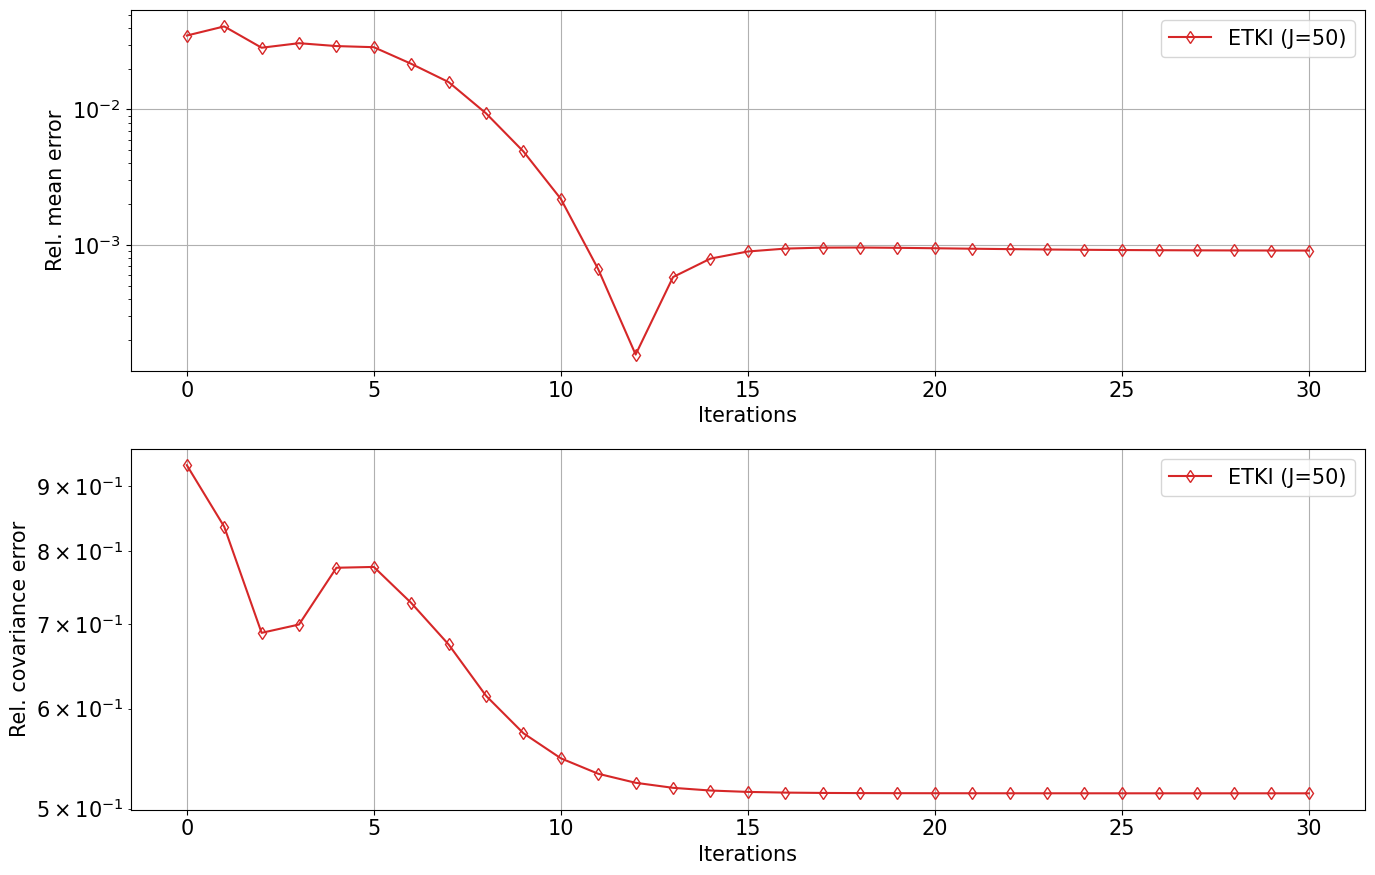

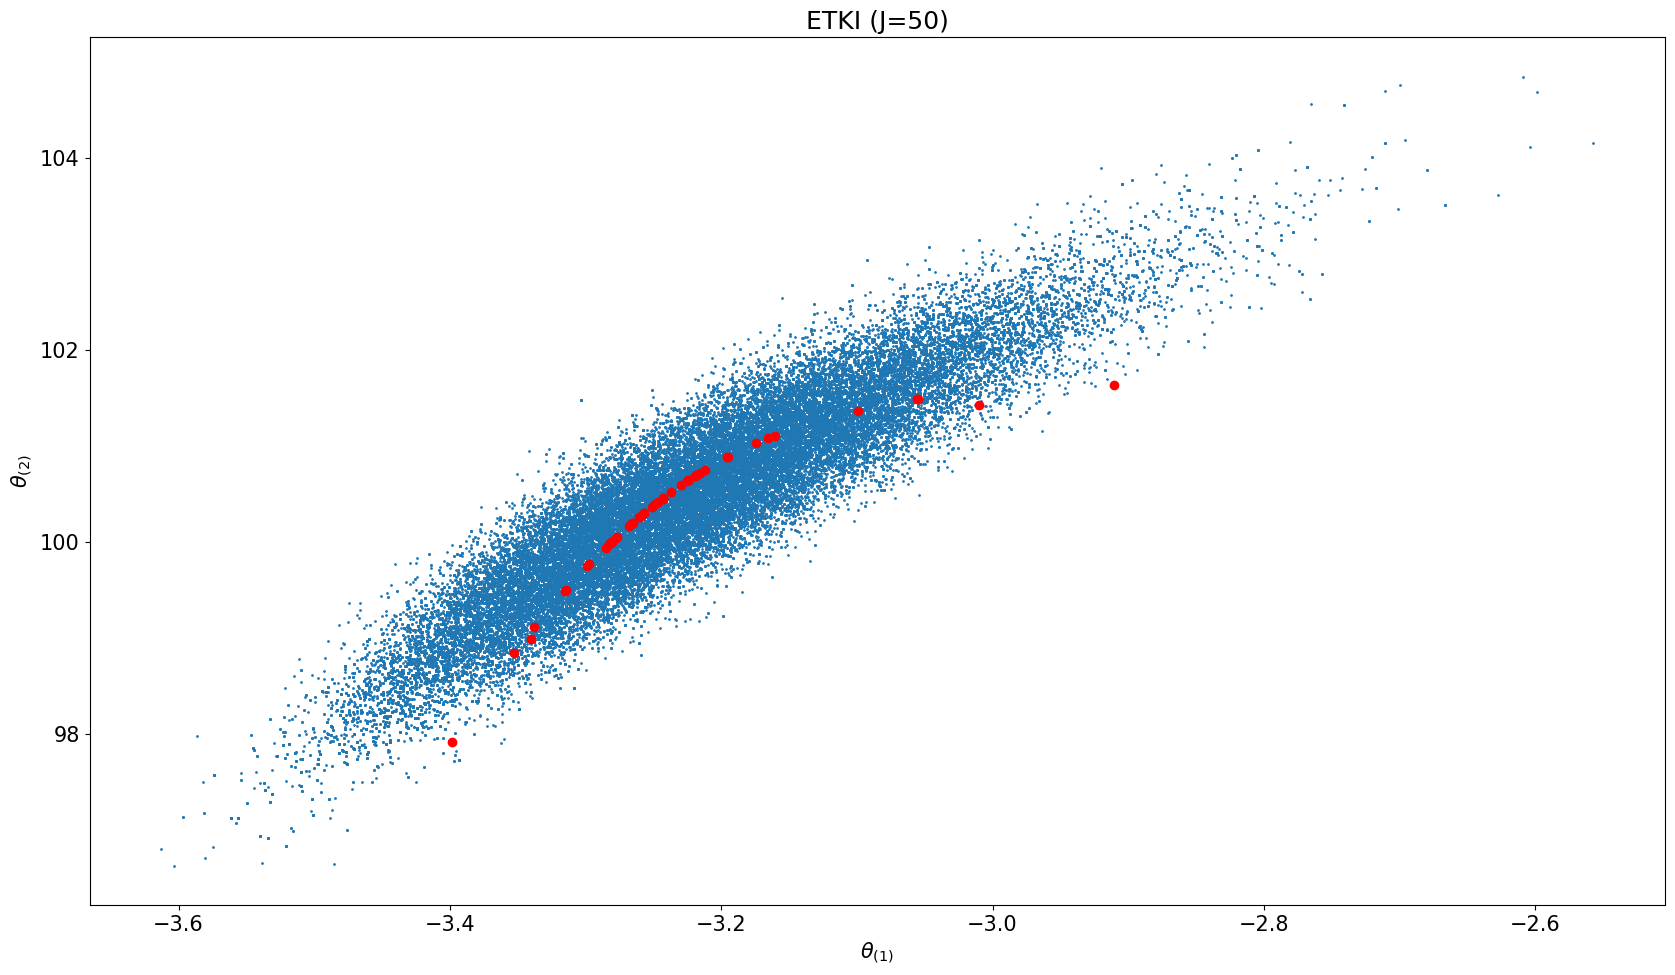

In [7]:
problem_type = "under-determined"
μ0 = np.array([0.0, 100.0])
Σ0 = np.array([[1.0**2, 0.0], [0.0, 1.0**2]])
Nt, N_ens = 30, 50
Elliptic_Posterior_Plot(problem_type, μ0, Σ0, Nt, N_ens)

start Elliptic_Posterior_Plot
start RWMCMC
start ETKI
Start ETKI on the mean-field stochastic dynamical system for Bayesian inference


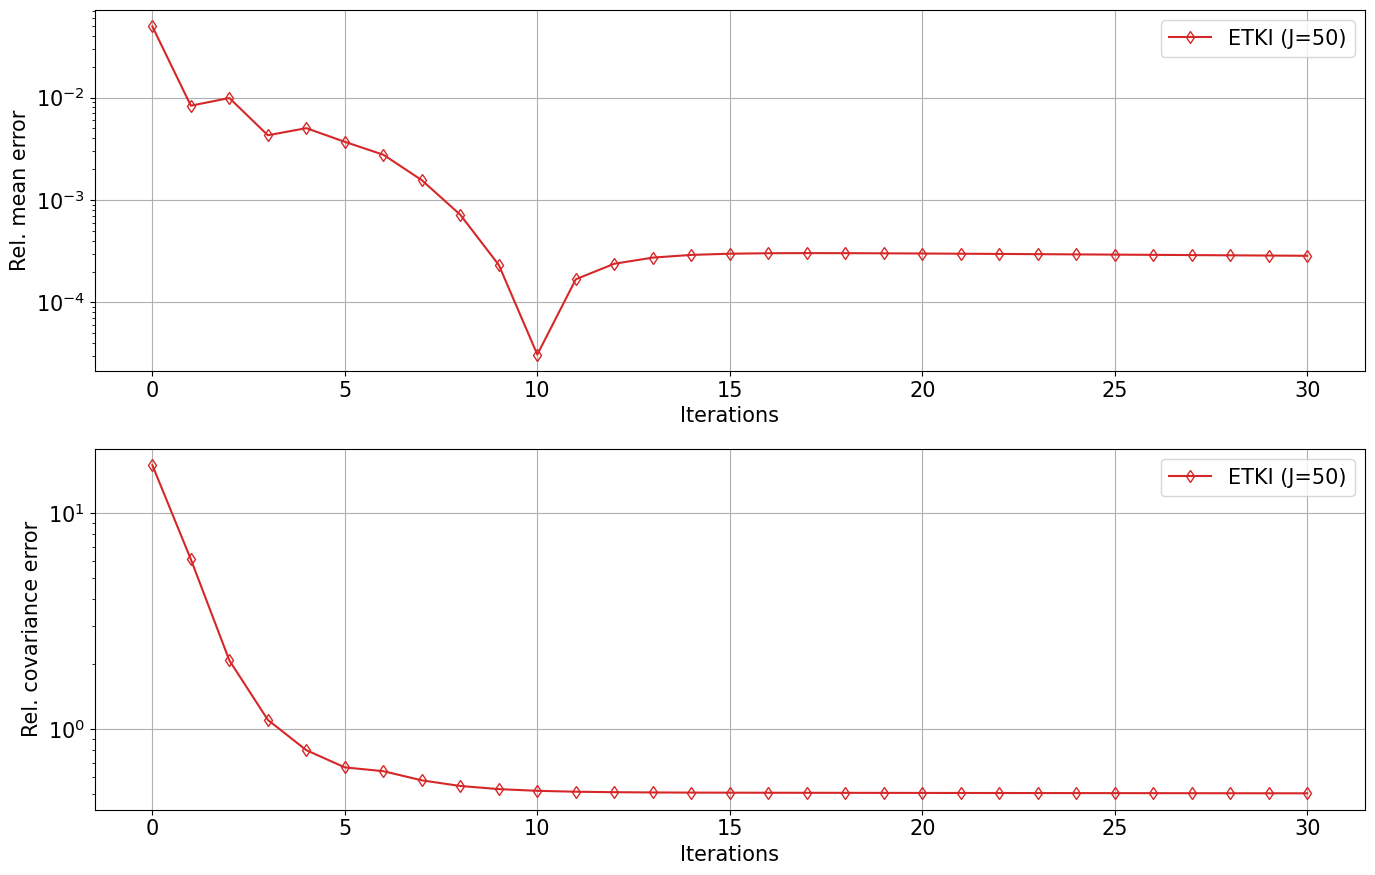

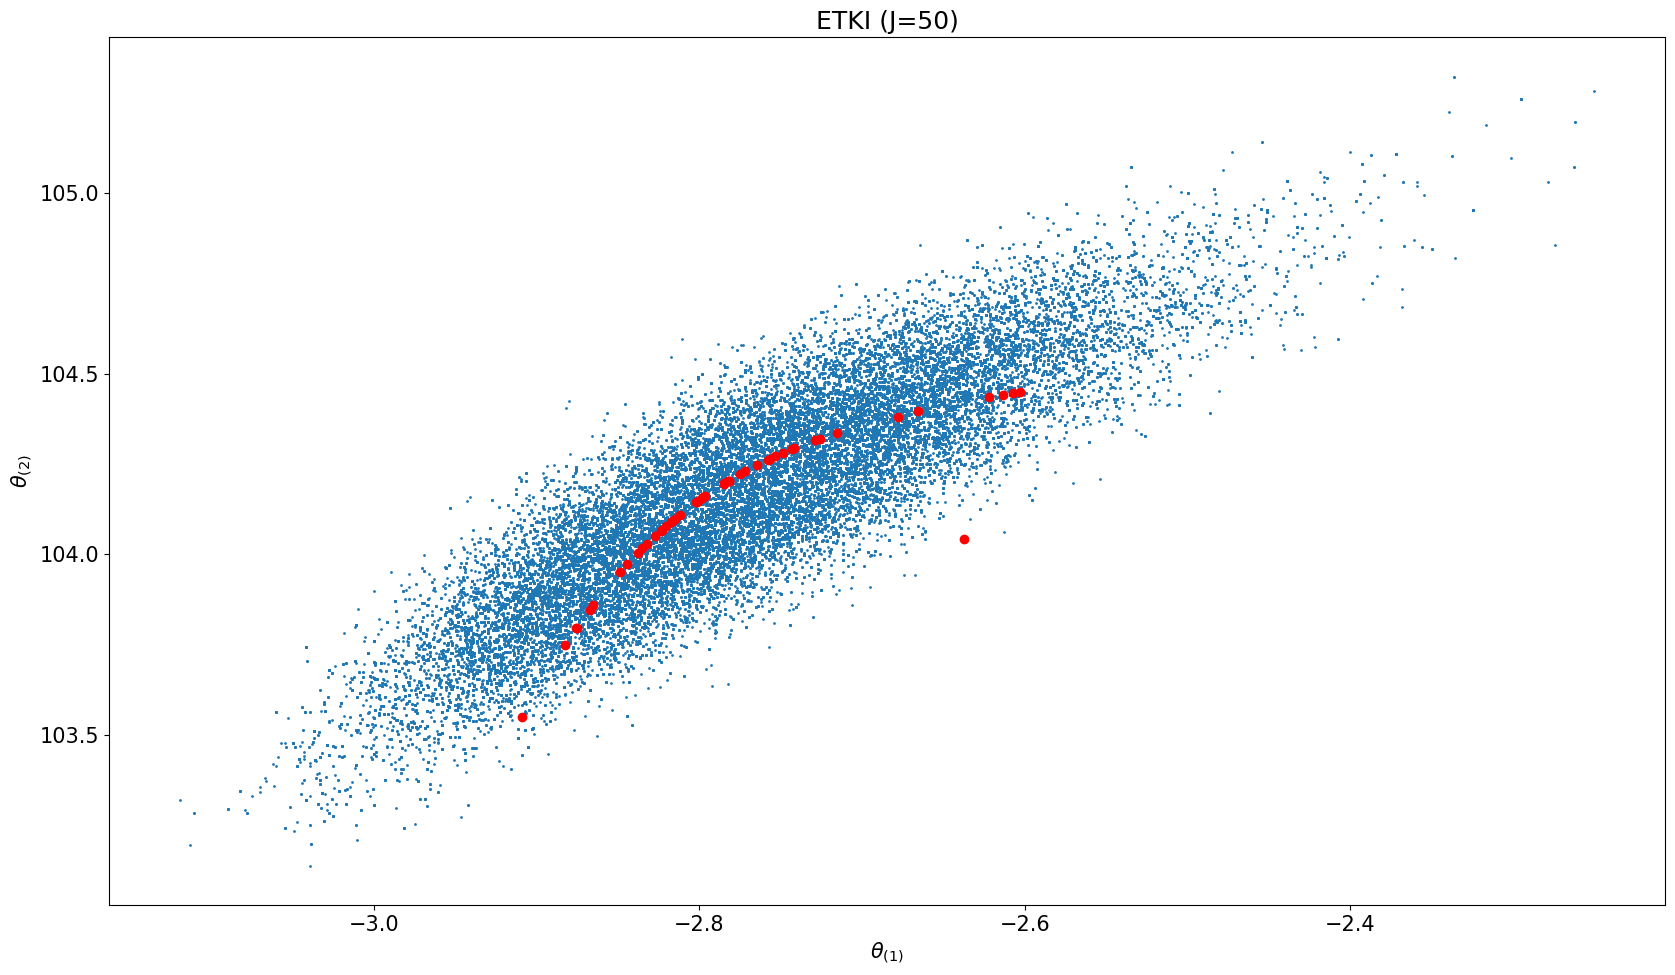

In [8]:
import numpy as np

problem_type = "well-determined"
μ0 = np.array([0.0, 100.0])
Σ0 = np.array([[1.0**2, 0.0], [0.0, 1.0**2]])
Nt, N_ens = 30, 50
Elliptic_Posterior_Plot(problem_type, μ0, Σ0, Nt, N_ens)